In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import math
from PIL import ImageEnhance
from PIL import Image, ImageFilter
import os
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc as misc

In [2]:
def resize(src_img, height, width):
    """
    双线性插值法,来调整图片尺寸

    :param org_img: 原始图片
    :param dst_shape: 调整后的目标图片的尺寸
    :return:    返回调整尺寸后的图片矩阵信息
    """
    dst_img = np.zeros((height, width, 3), np.uint8)
    dst_h, dst_w = height, width
    src_h = src_img.shape[0]
    src_w = src_img.shape[1]
    # i：纵坐标y，j：横坐标x
    # 缩放因子，dw,dh
    scale_w = src_w / dst_w
    scale_h = src_h / dst_h

    for i in range(dst_h):
        for j in range(dst_w):
            src_x = float((j + 0.5) * scale_w - 0.5)
            src_y = float((i + 0.5) * scale_h - 0.5)

            # 向下取整，代表靠近源点的左上角的那一点的行列号
            src_x_int = math.floor(src_x)
            src_y_int = math.floor(src_y)
            
            # 取出小数部分，用于构造权值
            src_x_float = src_x - src_x_int
            src_y_float = src_y - src_y_int

            if src_x_int + 1 == src_w or src_y_int + 1 == src_h:
                dst_img[i, j, :] = src_img[src_y_int, src_x_int, :]
                continue
            dst_img[i, j, :] = (1. - src_y_float) * (1. - src_x_float) * src_img[src_y_int, src_x_int, :] + \
                               (1. - src_y_float) * src_x_float * src_img[src_y_int, src_x_int + 1, :] + \
                               src_y_float * (1. - src_x_float) * src_img[src_y_int + 1, src_x_int, :] + \
                               src_y_float * src_x_float * src_img[src_y_int + 1, src_x_int + 1, :]
    return dst_img

In [48]:
# 图层混合算法 img1 在前，img2在后。注意此处的1是指的255， 0是0，0.5是128
# 不透明度
def Transparent(img_1, img_2, alpha):
    img = img_1 * alpha + img_2 * (1-alpha)
    return img.astype(np.uint8)

# 正片叠底
def Multiply (img_1, img_2):
    img = img_1 * img_2
    return img.astype(np.uint8).astype(np.uint8)

# 颜色加深 
def Color_burn (img_1, img_2):
    img = 1 - (1 - img_2) / (img_1 + 0.001)

    mask_1 = img  < 0 
    mask_2 = img  > 1

    img = img * (1-mask_1)
    img = img * (1-mask_2) + mask_2

    '''
    row, col, channel = img.shape
    for i in range(row):
        for j in range(col):
            img[i, j, 0] = min(max(img[i, j, 0], 0), 1)
            img[i, j, 1] = min(max(img[i, j, 1], 0), 1)
            img[i, j, 2] = min(max(img[i, j, 2], 0), 1)
    '''

    return img.astype(np.uint8)

# 颜色减淡
def Color_dodge(img_1, img_2):
    img = img_2 / (1.0 - img_1 + 0.001)
    mask_2 = img  > 1
    img = img * (1-mask_2) + mask_2          
    return img.astype(np.uint8)

# 线性加深 
def Linear_burn(img_1, img_2):
    img = img_1 + img_2 - 1
    mask_1 = img  < 0 
    img = img * (1-mask_1)
    return img.astype(np.uint8)

# 线性减淡
def Linear_dodge(img_1, img_2):
    img = img_1 + img_2
    mask_2 = img  > 255
    img = img * (1-mask_2) + mask_2
    return img.astype(np.uint8)

# 变亮
def Lighten(img_1, img_2):
    img = img_1 - img_2
    mask = img > 0
    img = img_1 * mask + img_2 * (1-mask) 

    return img.astype(np.uint8)

# 变暗
def Dark(img_1, img_2):
    img = img_1 - img_2
    mask = img < 0
    img = img_1 * mask + img_2 * (1-mask) 

    return img.astype(np.uint8)

# 滤色
def Screen(img_1, img_2):
    img = 1- (1-img_1)*(1-img_2)

    return img.astype(np.uint8)

# 叠加
def Overlay1(img_1, img_2):
    mask = img_2 < 0.5
    img = 2 * img_1 * img_2 * mask + (1-mask) * (1- 2 * (1-img_1)*(1-img_2))

    return img.astype(np.uint8)

def Overlay(img_1, img_2):
    mask = img_2 <= 128
    img = img_1 * img_2 * mask + (1-mask) * (255- (255-img_1)*(255-img_2)/2)

    return img.astype(np.uint8)

# 柔光
def Soft_light(img_1, img_2):
    mask = img_1 < 0.5
    T1 = (2 * img_1 -1)*(img_2 - img_2 * img_2) + img_2
    T2 = (2 * img_1 -1)*(np.sqrt(img_2) - img_2) + img_2
    img = T1 * mask + T2 * (1-mask)

    return img.astype(np.uint8)

# 强光
def Hard_light(img_1, img_2):
    mask = img_1 < 0.5
    T1 = 2 * img_1 * img_2
    T2 = 1 - 2 * (1 - img_1) * (1 - img_2)
    img = T1 * mask + T2 * (1-mask)

    return img.astype(np.uint8)

# 亮光
def Vivid_light(img_1, img_2):
    mask = img_1 < 0.5
    T1 = 1 - (1 - img_2)/(2 * img_1 + 0.001)
    T2 = img_2 / (2*(1-img_1) + 0.001)
    mask_1 = T1 < 0
    mask_2 = T2 > 1
    T1 = T1 * (1-mask_1)
    T2 = T2 * (1-mask_2) + mask_2
    img = T1 * mask  + T2 * (1 - mask) 

    return img.astype(np.uint8)

# 点光
def Pin_light(img_1, img_2):
    mask_1 = img_2 < (img_1 * 2 -1)
    mask_2 = img_2 > 2 * img_1
    T1 = 2 * img_1 -1 
    T2 = img_2
    T3 = 2 * img_1 
    img = T1 * mask_1 + T2 * (1 - mask_1) * (1 - mask_2) + T3 * mask_2

    return img.astype(np.uint8)

# 线性光
def Linear_light(img_1, img_2):
    img = img_2 + img_1 * 2 - 1
    mask_1 = img < 0
    mask_2 = img > 1
    img = img * (1-mask_1)
    img = img * (1-mask_2) + mask_2

    return img.astype(np.uint8)

# 实色混合
def Hard_mix(img_1, img_2):
    img = img_1 + img_2 
    mask = img_1 + img_2 > 1 
    img = img * (1-mask) + mask 
    img = img * mask
    return img.astype(np.uint8)

# img = Transparent(img_1, img_2, alpha)
# img = Multiply (img_1, img_2)
# img = Color_burn(img_1, img_2)
# img = Color_dodge(img_1, img_2)
# img = Linear_burn(img_1, img_2)
# img = Linear_dodge(img_1, img_2)
# img = Lighten(img_1, img_2)
# img = Dark (img_1, img_2)
# img = Screen(img_1, img_2)
# img = Overlay(img_1, img_2)
# img = Soft_light(img_1, img_2)
# img = Hard_light(img_1, img_2)
# img = Vivid_light(img_1, img_2)
# img = Pin_light(img_1, img_2)
# img = Linear_light(img_1, img_2)

In [4]:
def GaussianFilter(img, K_size=3, sigma=1):
    # 高斯滤波 k = 3, sigma = 1
    if len(img.shape) == 2:
        img = img.reshape((img.shape[0], img.shape[1], -1))
    h,w,c = img.shape
    
    # 零填充
    pad = K_size//2
    out = np.zeros((h + 2*pad,w + 2*pad,c),dtype=np.float)
    out[pad:pad+h,pad:pad+w] = img.copy().astype(np.float)
    
    # 定义滤波核
    K = np.zeros((K_size,K_size),dtype=np.float)
    
    for x in range(-pad,-pad+K_size):
        for y in range(-pad,-pad+K_size):
            K[y+pad,x+pad] = np.exp(-(x**2+y**2)/(2*(sigma**2)))
    K /= (sigma*np.sqrt(2*np.pi))
    K /=  K.sum()
    
    # 卷积的过程
    tmp = out.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                out[pad+y,pad+x,ci] = np.sum(K*tmp[y:y+K_size,x:x+K_size,ci])
    
    out = out[pad:pad+h,pad:pad+w].astype(np.uint8)
    
    return out

In [5]:
def gray(img, method=2):
    if method == 0:
        # 权重灰度化
        w = [0.299, 0.587, 0.114]
        img_gray = np.dot(img, w)
    if method == 1:
        # 平均值灰度化
        img_gray = img.mean(axis=-1)
    if method == 2:
        # 专业灰度化
        Color_ratio = np.zeros(6)

        Color_ratio[0]=0.4;     # Red
        Color_ratio[1]=0.6;     # Yellow
        Color_ratio[2]=0.4;     # Green
        Color_ratio[3]=0.6;     # Cyan
        Color_ratio[4]=0.2;     # Blue
        Color_ratio[5]=0.8;     # Magenta

        max_val = img.max(axis = 2)
        min_val = img.min(axis = 2)
        sum_val = img.sum(axis = 2)
        mid_val = sum_val - max_val - min_val

        mask_r = (img[:, :, 0] - min_val - 0.01) > 0 
        mask_r = 1 - mask_r
        mask_g = (img[:, :, 1] - min_val - 0.01) > 0
        mask_g = 1 - mask_g
        mask_b = (img[:, :, 2] - min_val - 0.01) > 0
        mask_b = 1 - mask_b

        ratio_max_mid = mask_r * Color_ratio[3] + mask_g * Color_ratio[5] + mask_b * Color_ratio[1]

        mask_r = (img[:, :, 0] - max_val + 0.01) < 0
        mask_r = 1 - mask_r

        mask_g = (img[:, :, 1] - max_val + 0.01) < 0
        mask_g = 1 - mask_g

        mask_b = (img[:, :, 2] - max_val + 0.01) < 0
        mask_b = 1 - mask_b

        ratio_max= mask_r * Color_ratio[4] + mask_g * Color_ratio[0] + mask_b * Color_ratio[2]

        I_out = max_val * 1.0 

        img_gray = (max_val-mid_val)*ratio_max + (mid_val-min_val)*ratio_max_mid + min_val 
    return img_gray

In [261]:
def show(img, cmap=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
    ax.axis('off')
    if cmap:
        plt.imshow(img.astype(np.uint8), cmap="gray")
    else:
        plt.imshow(img.astype(np.uint8))
    #         plt.savefig("./img/color.jpg")
def save(img, cmap=None, name="result"):
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
    ax.axis('off')
    if cmap:
        plt.imshow(img.astype(np.uint8), cmap="gray")
    else:
        plt.imshow(img.astype(np.uint8))
    plt.savefig("./img/{}.jpg".format(name), dpi=300)

In [259]:
def create_color_map(height, width):
    # 手动创造一个 height, width 的渐变矩阵 
    # https://matplotlib.org/stable/gallery/color/colormap_reference.html
    cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]
    cm = plt.get_cmap('PuRd')

    gradient = np.linspace(0, 1, width)
    gradient = gradient.reshape((width, -1))
    color_img = gradient.repeat(height, axis=1).transpose(1,0)
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
    ax.axis('off')
    plt.imshow(color_img)
    plt.savefig("./img/color.jpg")

def my_color(height, width, color_list=[[255,174,34], [201,60,250], [255,60,62], [36,207,255], [48,255,204]]):
    groups = len(cl) - 1
    # 前面几组的长度
    w = int(width / groups)
    # 最后一组的长度
    wn = width - (groups-1) * w

    color = np.zeros((1, width, 3))

    for i in range(groups-1):
        gradient = np.linspace(cl[i], cl[i+1], w)
        color[0][i*w:(i+1)*w] = gradient

    gradient = np.linspace(cl[-2], cl[-1], wn)
    color[0][width-wn:] = gradient
    # 重复 height 次，填充纵轴
    color = color.repeat(height, axis=0).astype('uint8')
    
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
    ax.axis('off')
    plt.imshow(color)
    plt.savefig("./img/color.png", dpi=300)
    return color

In [8]:
#中值滤波
def mid_functin(img, a, b):
    (h, w) = img.shape
    img = img.reshape(h, w, -1)
    img0 = img.copy()
    for i in range(0, img.shape[0]):
        for j in range(2, img.shape[1]):
            for k in range(img.shape[2]):
                temp = original(i, j, k, a, b, img0)
                img[i, j, k] = np.median(temp)
    return img

#最大值滤波
def max_functin(img, a, b):
    (h, w) = img.shape
    img = img.reshape(h, w, -1)
    img0 = img.copy()
    for i in range(0, img.shape[0]):
        for j in range(2, img.shape[1]):
            for k in range(img.shape[2]):
                temp = original(i, j, k, a, b, img0)
                img[i, j, k] = np.max(temp)
    return img

#最小值滤波
def min_functin(img, a, b):
    (h, w) = img.shape
    img = img.reshape(h, w, -1)
    img0 = img.copy()
    for i in range(0, img.shape[0]):
        for j in range(2, img.shape[1]):
            for k in range(img.shape[2]):
                temp = original(i, j, k, a, b, img0)
                img[i, j, k] = np.min(temp)
    return img

def original (i, j, k,a, b,img):
    x1, x2 = spilt(a)
    y1, y2 = spilt(b)
    temp = np.zeros(a * b)
    count = 0
    for m in range(x1, x2):
        for n in range(y1, y2):
            if i + m < 0 or i + m > img.shape[0] - 1 or j + n < 0 or j + n > img.shape[1] - 1:
                temp[count] = img[i, j, k]
            else:
                temp[count] = img[i + m, j + n, k]
            count += 1
    return  temp 

def spilt( a ):
    if a%2 == 0:
        x1 = x2 = a/2
    else:
        x1 = math.floor( a/2 )
        x2 = a - x1
    return -x1,x2

第一步：导入图片 img1 渐变图层 img2，调整渐变图像尺寸

第二补：灰度化 img3

第三步：灰度反色 img4，和灰度图片 img3 混合，模式颜色减淡 img5

第四步：img5 滤镜-其他-最小值（数值1）img6

第五步：img6 和 img2 叠加混合模式

渐变色参考 ffae22, c93cfa, ff3c3e, 24cfff, 30ffcc

In [184]:
img_path = "./img/mrx.jpg"
print(os.path.exists(img_path))

img = matplotlib.image.imread(img_path)
height = img.shape[0]
width = img.shape[1]

True


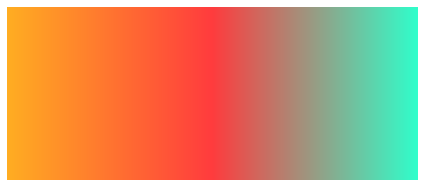

In [198]:
a = [255,174,34]
b = [201,60,250]
c = [255,60,62]
d = [36,207,255]
e = [48,255,204]
img_color = my_color(height, width, [a, b, c, d, e])

In [195]:
# color_path = "./img/color.png"
# img_color = matplotlib.image.imread(color_path)

# 如果用其他的颜色图片需要先resize
# img_color = resize(img_color, height, width)

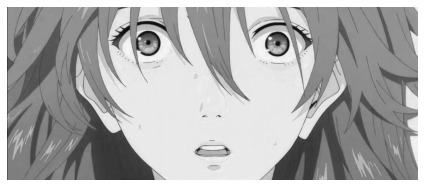

In [170]:
img_gray = gray(img)
show(img_gray, cmap="gray")

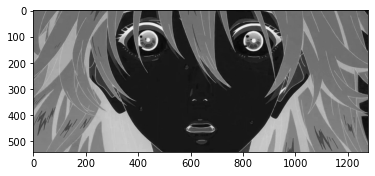

In [171]:
# 反色
img_oppsite = 255 - img_gray
plt.imshow(img_oppsite, cmap="gray")

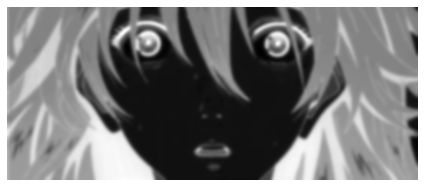

In [266]:
from scipy.ndimage import gaussian_filter
# 将反色图片模糊化处理
blur_img = gaussian_filter(img_oppsite, sigma=5)
show(blur_img, cmap="gray")

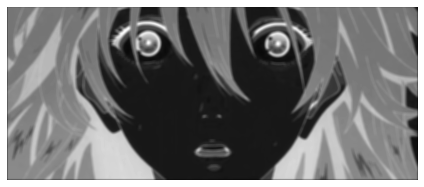

In [271]:
blur_img2 = GaussianFilter(img_oppsite, K_size=10, sigma=50)
show(blur_img2, cmap="gray")

In [175]:
def dodge(front, back): 
    result=front*255/(255-back)
    result[result>255]=255
    result[back==255]=255
    return result.astype('uint8')

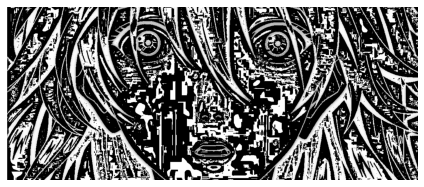

In [176]:
img4 = Linear_dodge(blur_img, img_gray)
show(img4, cmap="gray")

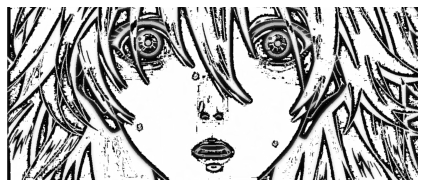

In [177]:
img4 = Linear_burn(blur_img, img_gray)
show(img4, cmap="gray")

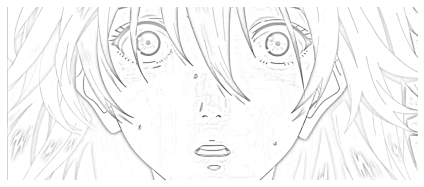

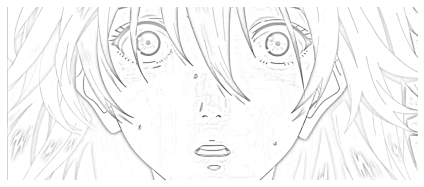

In [205]:
final_img= dodge(blur_img, img_gray)
# show(final_img, cmap="gray")
save(final_img, cmap="gray", name="1")

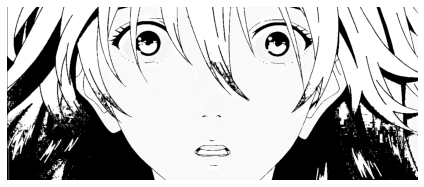

In [179]:
img5 = Color_dodge(img_oppsite, img_gray)
show(img5, "gray")

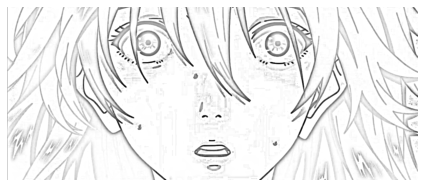

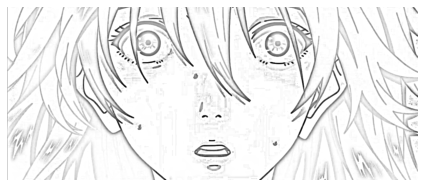

In [206]:
# 最小值滤镜
img_min = min_functin(final_img.copy(), 3, 3)
# show(img_min, "gray")
save(img_min, cmap="gray", name="2")

In [255]:
# 是否高斯模糊
img_final = img_min
img_final = GaussianFilter(img_final)
# 维数不足
img_final = img_final.repeat(3, axis=-1).astype('uint8')

In [256]:
# 将暗部对应位置上色,threshold是暗部判定
threshold = 230
h, w, c = img_final.shape
result = img_final.copy()
for i in range(h):
    for j in range(w):
        if img_final[i][j].mean() < threshold:
            result[i][j] = img_color[i][j]

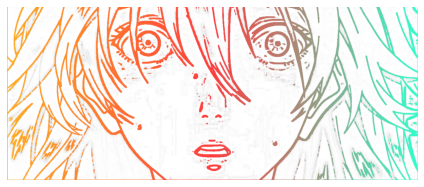

In [257]:
show(result)

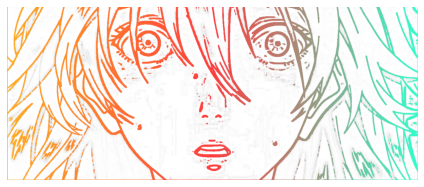

In [262]:
save(result, name="result")

# 第五步，有问题 overlay 始终不对

In [199]:
img_re = Overlay(img_color, img_min.reshape(height, width, -1))

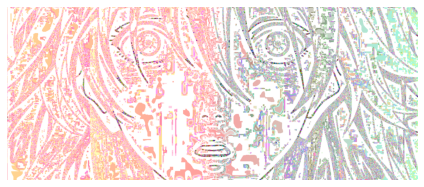

In [200]:
save(img_re)

In [201]:
img_re = Overlay(img_color, final_img.reshape(height, width, -1))

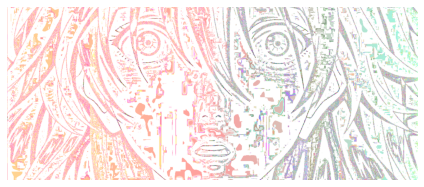

In [202]:
save(img_re)

In [236]:
img_path = "./img/1.jpg"
img = matplotlib.image.imread(img_path)
img_path = "./img/color.jpg"
color = matplotlib.image.imread(img_path)

In [237]:
img_re = Overlay(color, img)

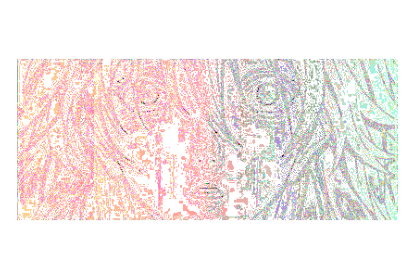

In [238]:
show(img_re)

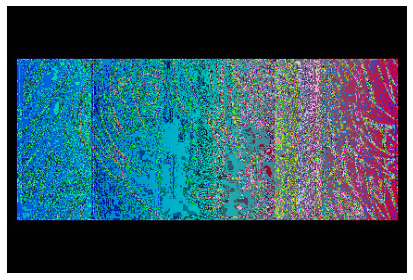

In [243]:
show(Multiply(color, img))

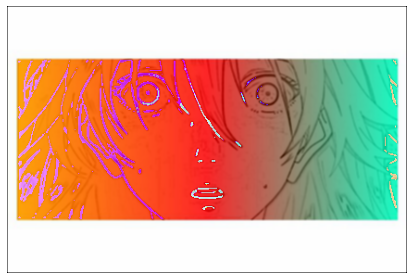

In [242]:
image_final = color*1.1 + img*0.9
im = GaussianFilter(image_final)
show(im)

# 3 维混合

In [32]:
img_result = img_min.reshape(height, width) + img_gray

In [33]:
for i in range(height):
    for j in range(width):
        if img_result[i, j]< 255*0.95:
            img_result[i, j] = img_result[i, j] * 0.39

In [34]:
img_result2 = img_result.reshape((height, width, 1)).repeat(3, axis=-1)

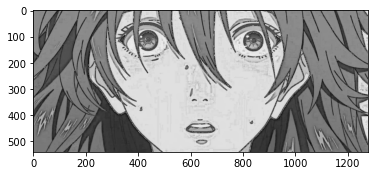

In [35]:
show(img_result2)

In [215]:
image_final = img_color*1.1 + img_result2*0.9

ValueError: operands could not be broadcast together with shapes (288,432,3) (540,1279,3) 

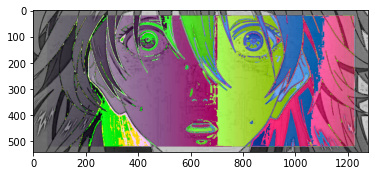

In [37]:
show(image_final)

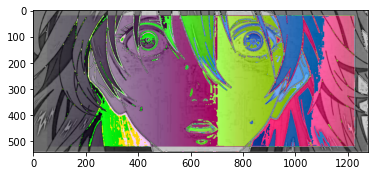

In [38]:
im = GaussianFilter(image_final)
show(im)